# Make figures for Lecture 2: Isostasy and Plate Flexure

This notebook uses the data in the `data` folder to make figures for the first lecture. Some require data processing as well.

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As always, start by importing the packages that we need.

In [1]:
import bz2
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import verde as vd
# Gravity and magnetics processing and modelling
import harmonica as hm
# Geodetic ellipsoids and their gravity
import boule as bl

## Profile of topography/bathymetry

Plot a map of Earth relief with a profile location and extract a profile across the Altantic to see what it looks like.

In [2]:
topo = xr.open_dataarray("../../data/earth_relief_10m.grd")
topo

<xarray.DataArray 'z' (lat: 1081, lon: 2161)>
[2336041 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -180.0 -179.8 -179.7 -179.5 ... 179.7 179.8 180.0
  * lat      (lat) float64 -90.0 -89.83 -89.67 -89.5 ... 89.5 89.67 89.83 90.0
Attributes:
    long_name:     elevation (m)
    actual_range:  [-10399.   6280.]

In [3]:
interpolator = vd.Chain([
    ("blockmean", vd.BlockReduce(np.mean, spacing=0.5)),
    ("interpolate", vd.ScipyGridder(method="nearest"))
])    

In [4]:
interpolator.fit(np.meshgrid(topo.lon, topo.lat), topo.values)

Chain(steps=[('blockmean',
              BlockReduce(adjust='spacing', center_coordinates=False,
                          drop_coords=True,
                          reduction=<function mean at 0x7fce240d83a0>,
                          region=None, shape=None, spacing=0.5)),
             ('interpolate', ScipyGridder(extra_args=None, method='nearest'))])

In [5]:
profile_start = (-55, -10)
profile_end = (25, 0)

In [6]:
topo_profile = interpolator.profile(point1=profile_start, point2=profile_end, size=200)
# Convert the distance from degrees to kilometers
topo_profile.distance *= 111 
# And the topography from meters to kilometers
topo_profile.scalars /= 1000
print(topo_profile)

      northing   easting     distance   scalars
0   -10.000000 -55.00000     0.000000  0.282500
1    -9.949749 -54.59799    44.970382  0.407500
2    -9.899497 -54.19598    89.940765  0.364000
3    -9.849246 -53.79397   134.911147  0.331556
4    -9.798995 -53.39196   179.881530  0.345333
..         ...       ...          ...       ...
195  -0.201005  23.39196  8769.224571  0.435556
196  -0.150754  23.79397  8814.194953  0.434444
197  -0.100503  24.19598  8859.165336  0.438333
198  -0.050251  24.59799  8904.135718  0.487000
199   0.000000  25.00000  8949.106101  0.454833

[200 rows x 4 columns]


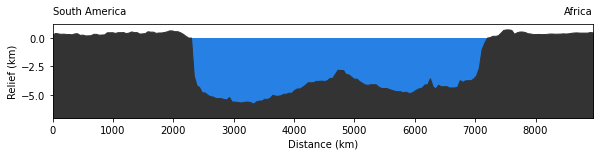

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.text(0, 1.1, "South America", transform=ax.transAxes)
ax.text(1, 1.1, "Africa", horizontalalignment="right", transform=ax.transAxes)
max_depth = -7
profile_bounds = [topo_profile.distance.min(), topo_profile.distance.max()]
ax.fill_between(profile_bounds, [0, 0], max_depth, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, max_depth, color='#333333')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile.png", dpi=200)
plt.show()

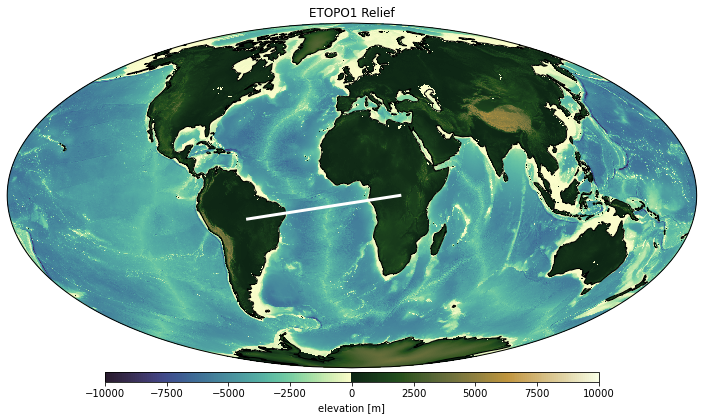

In [8]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("ETOPO1 Relief")
tmp = ax.pcolormesh(
    topo.lon, topo.lat, topo.values, 
    transform=ccrs.PlateCarree(), 
    vmin=-10000, vmax=10000, 
    cmap=cmocean.cm.topo
)
plt.colorbar(tmp, label="elevation [m]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.plot(topo_profile.easting, topo_profile.northing, "-w", linewidth=3, transform=ccrs.PlateCarree())
ax.coastlines()
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("topography-profile-location.png", dpi=200)
plt.show()

In [9]:
moho = -30
max_depth = -40

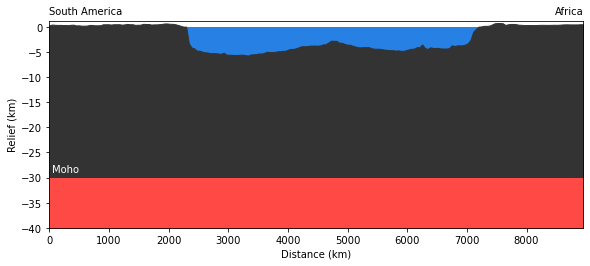

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho", color="white")
ax.fill_between(profile_bounds, [0, 0], moho, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, moho, color='#333333')
ax.fill_between(profile_bounds, [moho, moho], max_depth, color='#ff4945')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-hypothesis.png", dpi=200)
plt.show()

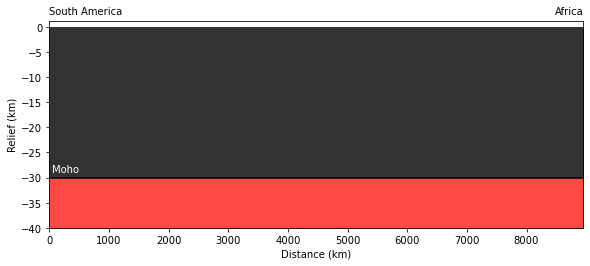

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho", color="white")
ax.plot(profile_bounds, [moho, moho], "-k")
ax.fill_between(profile_bounds, [0, 0], moho, color='#333333')
ax.fill_between(profile_bounds, [moho, moho], max_depth, color='#ff4945')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-normal-earth.png", dpi=200)
plt.show()

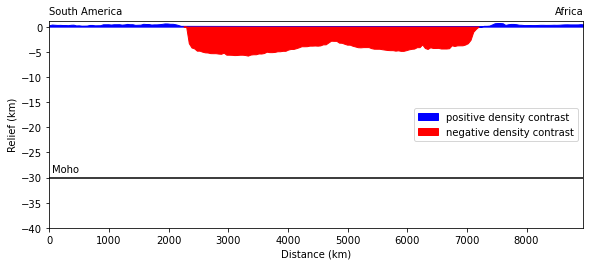

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho")
ax.plot(profile_bounds, [moho, moho], "-k")
continent = topo_profile.scalars > 0
ocean = np.logical_not(continent)
ax.fill_between(topo_profile.distance[continent], topo_profile.scalars[continent], 0, 
                color='blue', label="positive density contrast")
ax.fill_between(topo_profile.distance[ocean], np.zeros_like(topo_profile.distance[ocean]), topo_profile.scalars[ocean], 
                color='red', label="negative density contrast")
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.legend(loc="center right")
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-disturbance.png", dpi=200)
plt.show()

In [13]:
predicted_gravity = hm.bouguer_correction(topo_profile.scalars * 1000)

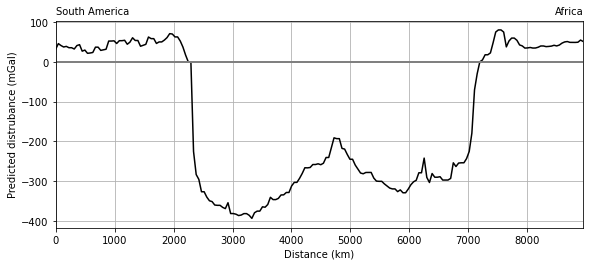

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.plot(topo_profile.distance, predicted_gravity, "-k")
ax.plot(profile_bounds, [0, 0], "-", color="gray", linewidth=2)
ax.set_ylabel("Predicted distrubance (mGal)")
ax.grid()
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("gravity-profile-predicted.png", dpi=200)
plt.show()

## Gravity disturbances of the Earth

Downloaded from http://icgem.gfz-potsdam.de/

In [15]:
with bz2.open("../../data/EIGEN-6C4-gravity-30m.gdf.bz2", "rt") as decompressed:
    gravity = hm.load_icgem_gdf(decompressed)
gravity

<xarray.Dataset>
Dimensions:          (latitude: 361, longitude: 721)
Coordinates:
  * longitude        (longitude) float64 -180.0 -179.5 -179.0 ... 179.5 180.0
  * latitude         (latitude) float64 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
Data variables:
    gravity_ell      (latitude, longitude) float64 9.801e+05 ... 9.802e+05
    height_over_ell  (latitude, longitude) float64 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    generating_institute:  gfz-potsdam
    generating_date:       2020/03/08
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       2190
    tide_system:           tide_free
    functional:            gravity_ell (centrifugal term included)
    unit:                  mgal
    refsysname:            WGS84
    gmrefpot:              3.98600441800E+14 m**3/s**2
    radiusrefpot:          6378137.000 m
    flatrefpot:            3.352810664747480E-03 (1/298.25722356300)
    omegarefpot:           7.29211500000E-05 1/s
    long_lat_unit:         degree
    latlimit_north:        90.000000000000
    latlimit_south:        -90.000000000000
    longlimit_west:        -180.00000000000
    longlimit_east:        180.00000000000
    gridstep:              0.50000000000000
    height_over_ell:       10000.0000 m
    latitude_parallels:    361
    longitude_parallels:   721
    number_of_gridpoints:  260281
    gapvalue:              9999999.0000
    weighted_mean:         9.7667903E+05 mgal
    maxvalue:              9.8019851E+05 mgal
    minvalue:              9.7475543E+05 mgal
    signal_wrms:           1.5468019E+03 mgal
    grid_format:           long_lat_value
    attributes:            longitude latitude gravity_ell
    attributes_units:      deg. deg. mgal

In [16]:
gravity_min, gravity_max = gravity.gravity_ell.min(), gravity.gravity_ell.max()

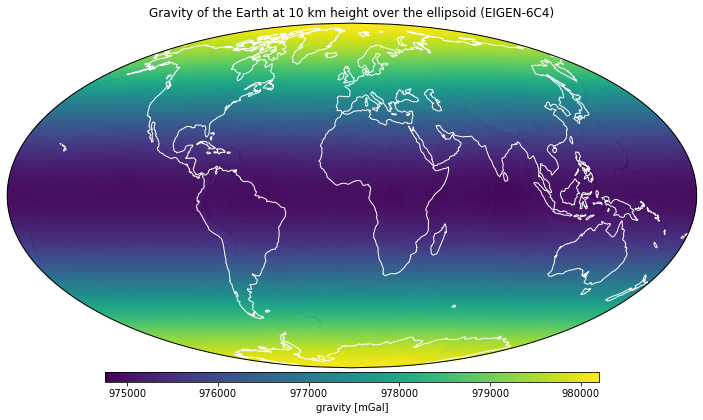

In [17]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Gravity of the Earth at 10 km height over the ellipsoid (EIGEN-6C4)")
tmp = ax.pcolormesh(
    gravity.longitude, gravity.latitude, gravity.gravity_ell, 
    transform=ccrs.PlateCarree(), 
    cmap="viridis",
    vmin=gravity_min, vmax=gravity_max,
)
plt.colorbar(tmp, label="gravity [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines(color="white")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-earth.png", dpi=200)
plt.show()

In [18]:
normal_gravity = bl.WGS84.normal_gravity(gravity.latitude, gravity.height_over_ell)

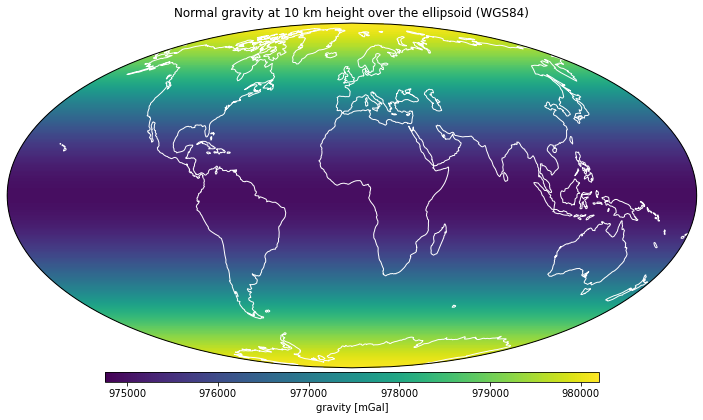

In [19]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Normal gravity at 10 km height over the ellipsoid (WGS84)")
tmp = ax.pcolormesh(
    gravity.longitude, gravity.latitude, normal_gravity, 
    transform=ccrs.PlateCarree(), 
    cmap="viridis",
    vmin=gravity_min, vmax=gravity_max,
)
plt.colorbar(tmp, label="gravity [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines(color="white")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-normal-earth.png", dpi=200)
plt.show()

In [20]:
disturbance = gravity.gravity_ell - normal_gravity

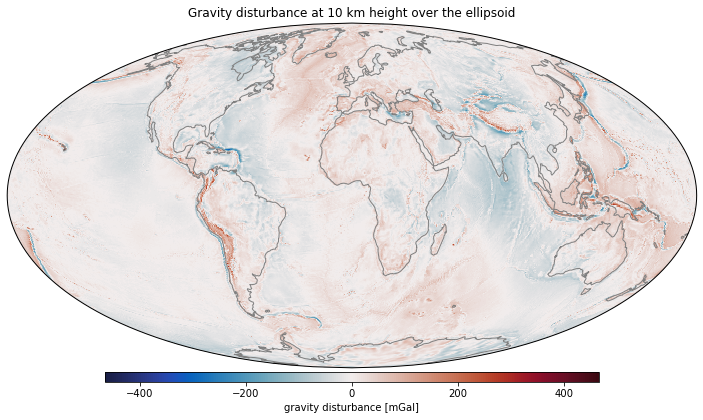

In [21]:
maxabs = vd.maxabs(disturbance)

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Gravity disturbance at 10 km height over the ellipsoid")
tmp = ax.pcolormesh(
    disturbance.longitude, disturbance.latitude, disturbance, 
    transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.balance,
    vmin=-maxabs, vmax=maxabs,
)
plt.colorbar(tmp, label="gravity disturbance [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.coastlines(color="gray")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-disturbance.png", dpi=200)
plt.show()

In [22]:
interpolator.fit(np.meshgrid(disturbance.longitude, disturbance.latitude), disturbance.values)

Chain(steps=[('blockmean',
              BlockReduce(adjust='spacing', center_coordinates=False,
                          drop_coords=True,
                          reduction=<function mean at 0x7fce240d83a0>,
                          region=None, shape=None, spacing=0.5)),
             ('interpolate', ScipyGridder(extra_args=None, method='nearest'))])

In [23]:
disturbance_profile = interpolator.profile(point1=profile_start, point2=profile_end, size=200)
disturbance_profile.distance *= 111

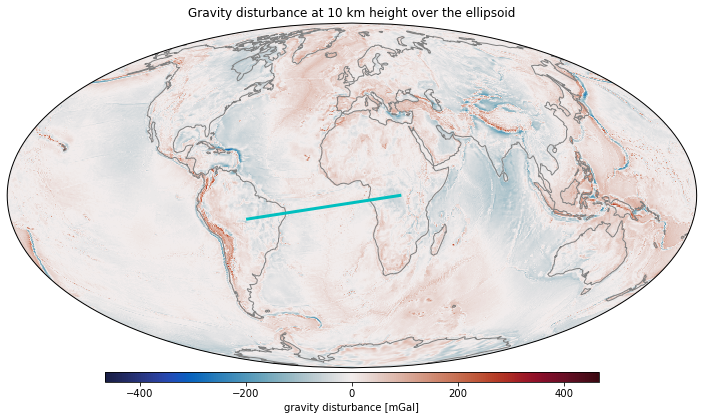

In [24]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("Gravity disturbance at 10 km height over the ellipsoid")
tmp = ax.pcolormesh(
    disturbance.longitude, disturbance.latitude, disturbance, 
    transform=ccrs.PlateCarree(), 
    cmap=cmocean.cm.balance,
    vmin=-maxabs, vmax=maxabs,
)
plt.colorbar(tmp, label="gravity disturbance [mGal]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.plot(disturbance_profile.easting, disturbance_profile.northing, "-c", linewidth=3, transform=ccrs.PlateCarree())
ax.coastlines(color="gray")
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("gravity-disturbance-profile.png", dpi=200)
plt.show()

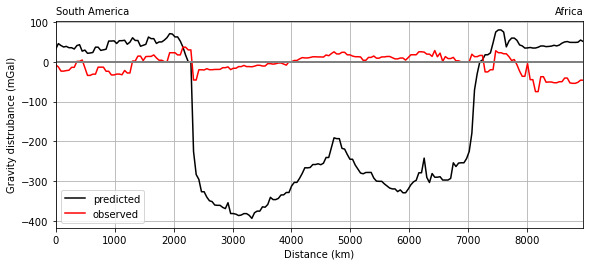

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.plot(topo_profile.distance, predicted_gravity, "-k", label="predicted")
ax.plot(disturbance_profile.distance, disturbance_profile.scalars, "-r", label="observed")
ax.plot(profile_bounds, [0, 0], "-", color="gray", linewidth=2)
ax.legend()
ax.set_ylabel("Gravity distrubance (mGal)")
ax.grid()
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("gravity-profile-predicted-vs-observed.png", dpi=200)
plt.show()

## Airy-Heiskanen compensantion

In [36]:
airy_moho = hm.isostasy_airy(topo_profile.scalars * 1000)
airy_moho /= -1000
airy_moho

0     -31.582000
1     -32.282000
2     -32.038400
3     -31.856711
4     -31.933867
         ...    
195   -32.439111
196   -32.432889
197   -32.454667
198   -32.727200
199   -32.547067
Name: scalars, Length: 200, dtype: float64

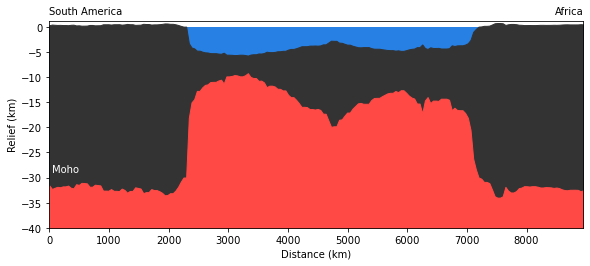

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho", color="white")
ax.fill_between(profile_bounds, [0, 0], moho, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, airy_moho, color='#333333')
ax.fill_between(topo_profile.distance, airy_moho, max_depth, color='#ff4945')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("topography-profile-airy.png", dpi=200)
plt.show()

In [86]:
ridge = np.logical_and(topo_profile.distance > 3500, topo_profile.distance < 6000)
ridge_topo = topo_profile.scalars[ridge]
ridge_distance = topo_profile.distance[ridge]
density_crust = 2800
density_water = 1040
compensation_depth = 30e3
pratt_density = (density_crust*compensation_depth - density_water*ridge_topo*-1e3) / (compensation_depth - ridge_topo*-1e3)

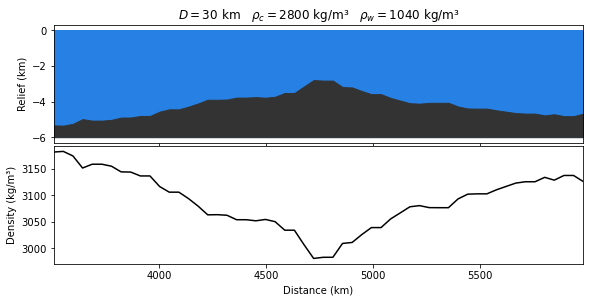

In [87]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 4))

ax = axes[0]
ax.set_title(f"$D = {compensation_depth/1e3:.0f}$ km   $\\rho_c = {density_crust}$ kg/m³   $\\rho_w = {density_water}$ kg/m³")
ax.fill_between([ridge_distance.min(), ridge_distance.max()], [0, 0], -6, color='#2780E3')
ax.fill_between(ridge_distance, ridge_topo, -6, color='#333333')
ax.set_ylabel('Relief (km)')

ax = axes[1]
ax.plot(ridge_distance, pratt_density, "-k")

ax.set_ylabel('Density (kg/m³)')
ax.set_xlabel('Distance (km)')
plt.xlim(ridge_distance.min(), ridge_distance.max())
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("density-pratt.png", dpi=200)
plt.show()

In [92]:
disturbance_reduced = vd.BlockReduce(np.median, spacing=0.5).filter(
    np.meshgrid(disturbance.longitude, disturbance.latitude), disturbance.values
)[1]

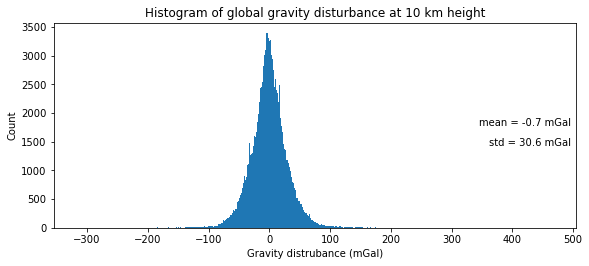

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.set_title("Histogram of global gravity disturbance at 10 km height")
ax.hist(disturbance_reduced, bins="auto")
ax.set_ylabel('Count')
ax.set_xlabel('Gravity distrubance (mGal)')
ax.text(0.99, 0.5, f"mean = {disturbance_reduced.mean():.1f} mGal", horizontalalignment="right", transform=ax.transAxes)
ax.text(0.99, 0.4, f"std = {disturbance_reduced.std():.1f} mGal", horizontalalignment="right", transform=ax.transAxes)
plt.tight_layout(h_pad=0, pad=0)
plt.savefig("disturbance-histogram.png", dpi=200)
plt.show()